# Team YSI - Titanic: Machine Learning from Disaster

## Version 1

In [1]:
#########################################################################
#
# Titanic: Machine Learning from Disaster
#
# Python script for generation of a model predicting the survivals.
#
# Amendment date             Amended by            Description
# 22/11/2016                 Ivaylo Shalev         Initial version.
# 26/11/2016                 Ivaylo Shalev         Added LR for Age missing values.
# 07/12/2016                 Ivaylo Shalev         Added ROC curve and LogReg
#
#
#########################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


# Reading of input data (train and test)
main_train_df = pd.read_csv('input/train.csv', header=0)      # Load the train file into a dataframe
main_test_df = pd.read_csv('input/test.csv', header=0)        # Load the test file into a dataframe

# The test data doesn't contain the target (survived), however it still can be used when we are doing data preparation
# That's why we create a third dataframe which will contain both training and test data into one.
# When executing the modeling we will split them back.
main_all_df = main_train_df.append(main_test_df)              # Create a union between both data frames

# Show some stats
print("Training data - number of rows: %s" %(main_train_df['PassengerId'].size))
print("Testing data - number of rows:  %s" %(main_test_df['PassengerId'].size))
print("Total data - number of rows:    %s" %(main_all_df['PassengerId'].size))
print("")

# training data
print("ALL DATA")
# show first row
print(main_all_df.iloc[0])
print("")
# show last row
print(main_all_df.iloc[-1])
print("")

Training data - number of rows: 891
Testing data - number of rows:  418
Total data - number of rows:    1309

ALL DATA
Age                                 22
Cabin                              NaN
Embarked                             S
Fare                              7.25
Name           Braund, Mr. Owen Harris
Parch                                0
PassengerId                          1
Pclass                               3
Sex                               male
SibSp                                1
Survived                             0
Ticket                       A/5 21171
Name: 0, dtype: object

Age                                 NaN
Cabin                               NaN
Embarked                              C
Fare                            22.3583
Name           Peter, Master. Michael J
Parch                                 1
PassengerId                        1309
Pclass                                3
Sex                                male
SibSp                        

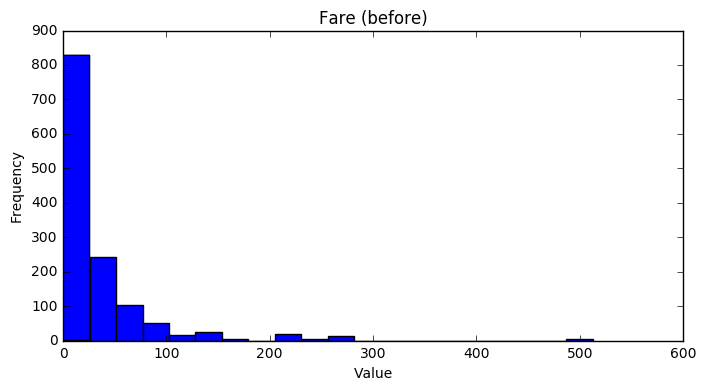

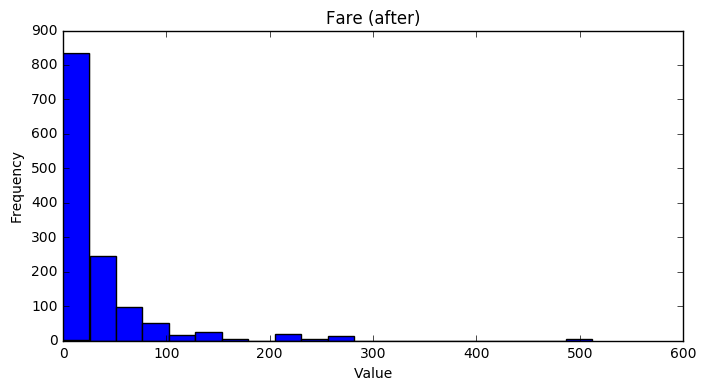

In [2]:
# Data Preparation

# PassengerId - do nothing (as it is - int), but it will not be used as a feature
# Pclass - do nothing (as it is - int 1,2,3)
# SibSp - do nothing (as it is - int 1,2,3,4,5,6,7,8)
# Parch - do nothing (as it is - int 1,2,3,4,5,6,7,8)

# Survived - convert to int
main_all_df['Survived'] = main_all_df.loc[np.isnan(main_all_df['Survived']) == False, 'Survived'].astype(int)

# Sex - convert it to ID (int): 0 - female, 1 - male
main_all_df['GenderId'] = [ 0 if x == 'female' else 1 for x in main_all_df['Sex'] ]

# Family Size - sum SibSp + Parch + 1
main_all_df['FamSize'] = main_all_df.SibSp + main_all_df.Parch + 1
main_all_df['FamSizeId'] = 1
main_all_df.loc[(main_all_df.FamSize > 1) & (main_all_df.FamSize <= 4), 'FamSizeId'] = 2
main_all_df.loc[(main_all_df.FamSize > 4) & (main_all_df.FamSize <= 7), 'FamSizeId'] = 3
main_all_df.loc[(main_all_df.FamSize > 7), 'FamSizeId'] = 4


# Name - extract family name and title
# Name - Surname
main_all_df['Surname'] = main_all_df['Name'].replace("(\\,..*)", "", regex=True)
main_all_df['SurnameId'] = main_all_df['Surname'] + "_" + main_all_df['FamSize'].astype(str)

# FamSizeNum
main_all_df['FamSizeNum'] = main_all_df['FamSize'] + main_all_df['Surname'].str.len()
#print(main_all_df.groupby('FamSizeNum').count()['PassengerId'])

# Name - Title - group common titles and factor them all
#print(main_all_df.groupby(['Sex','Title','Pclass']).count()['PassengerId'])
main_all_df['Title'] = main_all_df['Name'].replace("(.*, )|(\\..*)", "", regex=True)
common_titles = [
     ['Other', 0]
    
    ,["Miss", 1]
    ,["Mile", 1]
    ,["Ms", 1]
    
    ,["Mrs", 2]
    
    # First class female titles
    ,["Dona", 3]
    ,["Lady", 3]
    ,["Mme", 3]
    ,["the Countess", 3]
    
    ,["Mr", 4]
    
    ,["Master", 5]
    
    # First class male titles
    ,["Capt", 6]
    ,["Col", 6]
    ,["Jonkheer", 6]
    ,["Major", 6]
    ,["Sir", 6]
]
common_titles_dict = { title : i for title, i in common_titles }
main_all_df['TitleId'] = [ 'Other' if x not in list(common_titles_dict) else x for x in main_all_df['Title'] ]
main_all_df['TitleId'] = main_all_df['TitleId'].map( lambda x: common_titles_dict[x])


# Embarked - decode letter to ID (int)
main_all_df['EmbarkedId'] = [ 0 if np.isnan(x) else x.astype(int) for x in main_all_df['Embarked'].map(
        {
            'C': 1 # Cherbourg
         ,  'Q': 2 # Queenstown
         ,  'S': 3 # Southampton
        })]
# fill missing
main_all_df.loc[main_all_df["EmbarkedId"] == 0, 'EmbarkedId'] = 3 # S


# Child
main_all_df['Child'] = 0
main_all_df.loc[main_all_df.Age < 18, 'Child'] = 1

# Mother
main_all_df['Mother'] = 0
main_all_df.loc[  (main_all_df.Age >= 18)
                & (main_all_df.Parch > 0)
                & (main_all_df.GenderId == 0)
                & (main_all_df.Title != "Miss"), 'Mother'] = 1


# Fare - fill missing - just one - 1044
main_all_df.loc[main_all_df.PassengerId == 1044,'Fare'] = main_all_df.loc[(main_all_df.Pclass == 3) & (main_all_df.Embarked == "S"),'Fare'].median()

# FareGroupId
main_all_df['FareGroupId'] = main_all_df['Fare'].astype(int)
#main_all_df['FareGroupId'] = (main_all_df['Fare']/5).astype(int)*5
# 3 levels
#main_all_df['FareGroupId'] = 1
#main_all_df.loc[(main_all_df['Fare'] > 5) & (main_all_df['Fare'] <= 15), 'FareGroupId'] = 2
#main_all_df.loc[(main_all_df['Fare'] > 15), 'FareGroupId'] = 3
# 6 levels
#main_all_df['FareGroupId'] = 0
#main_all_df.loc[(main_all_df['Fare'] > 0) & (main_all_df['Fare'] <= 5), 'FareGroupId'] = 1
#main_all_df.loc[(main_all_df['Fare'] > 5) & (main_all_df['Fare'] <= 10), 'FareGroupId'] = 2
#main_all_df.loc[(main_all_df['Fare'] > 10) & (main_all_df['Fare'] <= 15), 'FareGroupId'] = 3
#main_all_df.loc[(main_all_df['Fare'] > 15) & (main_all_df['Fare'] <= 20), 'FareGroupId'] = 4
#main_all_df.loc[(main_all_df['Fare'] > 20), 'FareGroupId'] = 5

#print(main_all_df.groupby(['FareGroupId','Survived']).count()['PassengerId'])

plt.figure(figsize=(8,4))
plt.title('Fare (before)')
plt.xlabel('Value')
main_all_df['Fare'].plot.hist(bins=20)

plt.figure(figsize=(8,4))
plt.title('Fare (after)')
plt.xlabel('Value')
main_all_df['FareGroupId'].plot.hist(20)
plt.show()
#print(main_all_df.loc[(main_all_df.Fare.notnull()) & (main_all_df.Fare == 0),'Fare'])

Training Deck model...
Accuracy: 0.65 (+/- 0.08)
Predicting Deck...
Done.


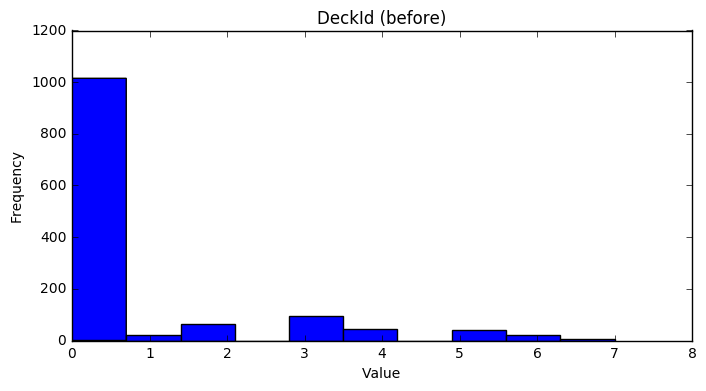

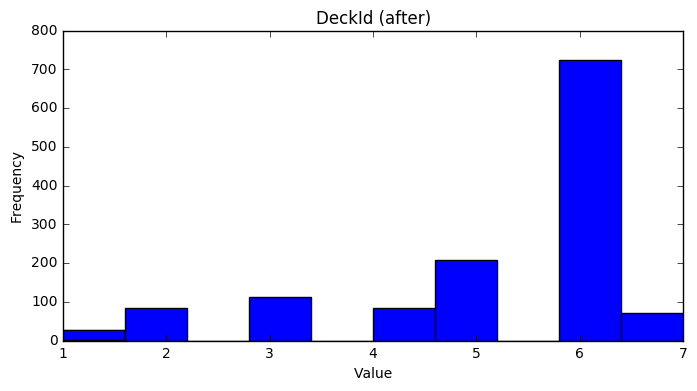

In [3]:
# Cabin - extract Deck letter and convert it to ID (int)
main_all_df['DeckId'] = [ 0 if np.isnan(x) else x.astype(int) for x in main_all_df['Cabin'].str[:1].map(
        {
           #'T': 1 # Boat Deck - most top - ignore (just 1 case)
            'A': 1 # higher
         ,  'B': 2
         ,  'C': 3
         ,  'D': 4
         ,  'E': 5
         ,  'F': 6
         ,  'G': 7 # lowest deck
        })]

# fill missing
plt.figure(figsize=(8,4))
plt.title('DeckId (before)')
plt.xlabel('Value')
main_all_df['DeckId'].plot.hist()

# create train and target df
all_deck_train_df = main_all_df[[
     'DeckId'
    ,'Pclass'
    ,'FareGroupId'
    #,'FamSizeId'
    ,'EmbarkedId'
    #,'Survived'
    #,'TitleId'
    #,'GenderId'
    #,'Child'
    #,'SibSp'
    #,'Parch'
    #,'Mother'
]]
deck_train_df = all_deck_train_df.loc[all_deck_train_df['DeckId'] != 0].copy()
deck_null_df = all_deck_train_df.loc[all_deck_train_df['DeckId'] == 0].copy()
deck_target_df = deck_train_df['DeckId'].copy()
deck_train_df.drop(['DeckId'], axis = 1, inplace=True)
deck_null_df.drop(['DeckId'], axis = 1, inplace=True)


# Linear Regression
print("Training Deck model...")
deck_train_model = RandomForestClassifier(n_estimators=100)

# Cross validation
scores = cross_validation.cross_val_score(deck_train_model
                                          ,deck_train_df
                                          ,deck_target_df
                                          ,cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std() * 2))

# Predict
print("Predicting Deck...")
deck_train_model = deck_train_model.fit(deck_train_df, deck_target_df)
deck_train_result = deck_train_model.predict(deck_null_df)
main_all_df.loc[main_all_df['DeckId'] == 0, 'DeckId'] = deck_train_result
print("Done.")


plt.figure(figsize=(8,4))
plt.title('DeckId (after)')
plt.xlabel('Value')
main_all_df['DeckId'].plot.hist()

plt.show()

Training Age model...
Accuracy: 0.45 (+/- 0.07)
Predicting Age...
Done.


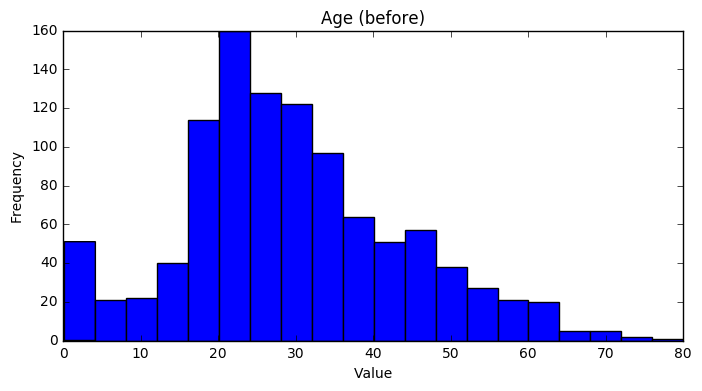

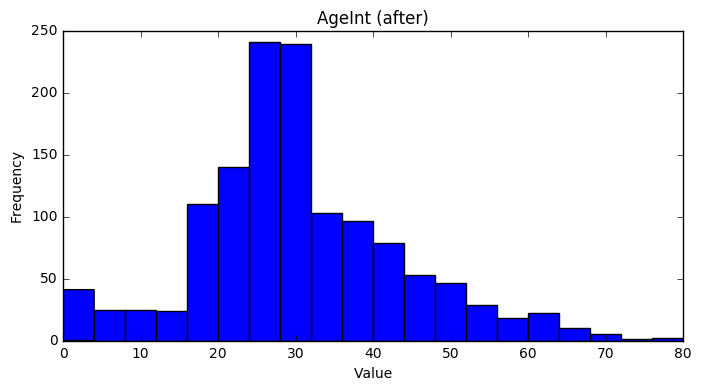

In [4]:
# Age - build regression model to fill the missing age values

plt.figure(figsize=(8,4))
plt.title('Age (before)')
plt.xlabel('Value')
main_all_df['Age'].plot.hist(bins=20)

# create train and target df
all_age_train_df = main_all_df[[
     'Age'
    ,'Survived'
    ,'TitleId'
    ,'GenderId'
    ,'Pclass'
    ,'Child'
    ,'FareGroupId'
    ,'FamSizeId'
    #,'FamSize'
    #,'FamSizeNum'
    ,'SibSp'
    ,'Parch'
    ,'Mother'
    #,'EmbarkedId'
    #,'DeckId'
    #,'Fare'
]]
age_train_df = all_age_train_df.loc[(np.isnan(all_age_train_df['Age'])==False)].copy() # get only non NULLs
age_null_df = all_age_train_df.loc[(np.isnan(all_age_train_df['Age']))].copy()         # get all NULLs
age_target_df = age_train_df['Age'].copy()
age_train_df.drop(['Age'], axis = 1, inplace=True)
age_null_df.drop(['Age'], axis = 1, inplace=True)

# Linear Regression
print("Training Age model...")
lreg = LinearRegression()

# Cross validation
scores = cross_validation.cross_val_score(lreg
                                          ,age_train_df
                                          ,age_target_df
                                          ,cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std() * 2))

# Predict
print("Predicting Age...")
lreg = lreg.fit(age_train_df, age_target_df)
lreg_result = lreg.predict(age_null_df)
main_all_df.loc[np.isnan(main_all_df['Age']), 'Age'] = lreg_result
main_all_df['AgeInt'] = [ 0 if (np.isnan(x)) or (1*(x/1).astype(int) == 0) else 1*(x/1).astype(int) for x in main_all_df['Age'] ]
print("Done.")

plt.figure(figsize=(8,4))
plt.title('AgeInt (after)')
plt.xlabel('Value')
main_all_df['AgeInt'].plot.hist(bins=20)

plt.show()

In [5]:
# Classification

# Split into Train and Test DF
# get only the good features, ID and Target
all_good_df = main_all_df[[
     'PassengerId'
    ,'Survived'
    ,'TitleId'
    ,'GenderId'
    ,'Age'
    #,'AgeInt'
    ,'Pclass'
    #,'Fare'
    ,'FareGroupId'
    #,'DeckId'
    ,'Child'
    #,'FamSizeId'
    #,'FamSize'
    ,'FamSizeNum'
    ,'SibSp'
    ,'EmbarkedId'
    #,'Parch'
    #,'Mother'
]]

# Split rows into original sets
train_df = all_good_df.ix[all_good_df.PassengerId <= 891]
test_df = all_good_df.ix[all_good_df.PassengerId > 891]

# Get ID and Target
test_ids = test_df['PassengerId'].values
target_df = all_good_df.ix[all_good_df.PassengerId <= 891, 'Survived']

# Remove ID and Target columns from the datasets
train_df = train_df.drop(['PassengerId', 'Survived'], axis = 1)
test_df = test_df.drop(['PassengerId', 'Survived'], axis = 1)

print(train_df.head())
print(test_df.head())

   TitleId  GenderId   Age  Pclass  FareGroupId  Child  FamSizeNum  SibSp  \
0        4         1  22.0       3            7      0           8      1   
1        2         0  38.0       1           71      0           9      1   
2        1         0  26.0       3            7      0          10      0   
3        2         0  35.0       1           53      0          10      1   
4        4         1  35.0       3            8      0           6      0   

   EmbarkedId  
0           3  
1           1  
2           3  
3           3  
4           3  
   TitleId  GenderId   Age  Pclass  FareGroupId  Child  FamSizeNum  SibSp  \
0        4         1  34.5       3            7      0           6      0   
1        2         0  47.0       3            7      0           8      1   
2        4         1  62.0       2            9      0           6      0   
3        4         1  27.0       3            8      0           5      0   
4        2         0  22.0       3           12      0  

In [6]:
random_state = np.random.RandomState(0)
fpr = dict()
tpr = dict()
roc_auc = dict()

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_df, target_df, test_size=0.5,
                                                    random_state=0)

# Learn to predict each class against the other
cls_svm_l =  OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=random_state))
y_score = cls_svm_l.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr[0], tpr[0], _ = roc_curve(y_test, y_score)
roc_auc[0] = auc(fpr[0], tpr[0])

# Another method: Random Forest
cls_rf = RandomForestClassifier(n_estimators = 100, random_state=random_state)
cls_rf = cls_rf.fit(X_train, y_train)
y_score = cls_rf.predict_proba(X_test)

# compute ROC for this method
fpr[1], tpr[1], _ = roc_curve(y_test, y_score[:,1])
roc_auc[1] = auc(fpr[1], tpr[1])

# Another method: Bayes SVM
cls_svm_b =  OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True, random_state=random_state))
y_score = cls_svm_b.fit(X_train, y_train).decision_function(X_test)

# compute ROC for this method
fpr[2], tpr[2], _ = roc_curve(y_test, y_score)
roc_auc[2] = auc(fpr[2], tpr[2])

# Another method: Logistic Regression
cls_lr = LogisticRegression(random_state=random_state)
y_score = cls_lr.fit(X_train, y_train).decision_function(X_test)

# compute ROC for this method
fpr[3], tpr[3], _ = roc_curve(y_test, y_score)
roc_auc[3] = auc(fpr[3], tpr[3])



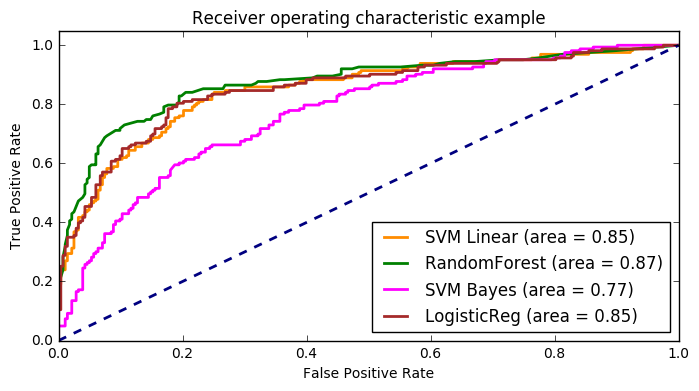

In [7]:
# Draw the ROC curves
plt.figure(figsize=(8,4))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='SVM Linear (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green',
         lw=lw, label='RandomForest (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='magenta',
         lw=lw, label='SVM Bayes (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='brown',
         lw=lw, label='LogisticReg (area = %0.2f)' % roc_auc[3])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [8]:
# Cross validation
'''
scores = cross_validation.cross_val_score(cls_svm_l
                                          ,train_df
                                          ,target_df
                                          ,cv=10
                                          #,scoring='accuracy')
                                          ,scoring='roc_auc')

print("SVM Linear - Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
'''
scores = cross_validation.cross_val_score(cls_rf
                                          ,train_df
                                          ,target_df
                                          ,cv=10
                                          #,scoring='accuracy')
                                          ,scoring='roc_auc')

print("Random Forest - Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
'''
scores = cross_validation.cross_val_score(cls_svm_b
                                          ,train_df
                                          ,target_df
                                          ,cv=10
                                          #,scoring='accuracy')
                                          ,scoring='roc_auc')

print("SVM Bayes - Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
'''
scores = cross_validation.cross_val_score(cls_lr
                                          ,train_df
                                          ,target_df
                                          ,cv=10
                                          #,scoring='accuracy')
                                          ,scoring='roc_auc')

print("Logistic Reg - Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Random Forest - Accuracy: 0.89 (+/- 0.08)
Logistic Reg - Accuracy: 0.86 (+/- 0.06)


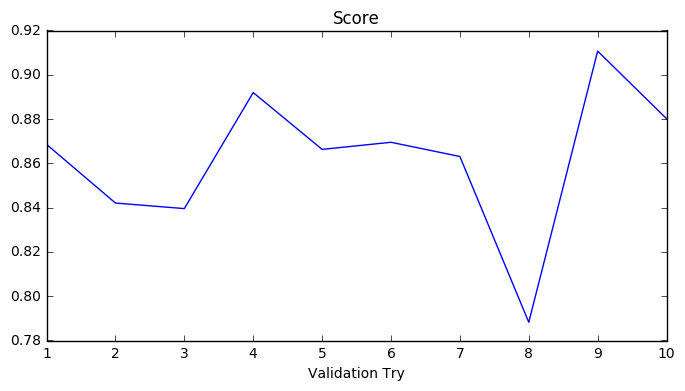

In [9]:
# Show scores
plt.figure(figsize=(8,4))
plt.title('Score')
plt.xlabel('Validation Try')
plt.plot(range(1,scores.size+1),scores.tolist())

plt.show()

In [10]:
# Predict
print("Predicting...")
cls_final = RandomForestClassifier(n_estimators = 100, random_state=random_state)
cls_final = cls_final.fit(train_df, target_df)
predict_output = cls_final.predict(test_df)
results_df = pd.DataFrame({'PassengerId': test_ids, 'Survived': predict_output})
# Save to CSV file
results_df.to_csv(path_or_buf="output/ysi_titanic_prediction.csv", index=False)
print("Done.")

Predicting...
Done.
